# 自然語言處理：Google評論資料探索

## 前言

> 在瞬息萬變的網路世界，若想要了解客戶對於公司的想法，縮短與客戶間的距離，我們當然可以透過發放問卷的方式來收集資料，但這種方式的缺點是需要花費較長的時間及人力。 另一種方式是我們可以直接到 Google Map 頁面抓取客戶的留言，搭配文字分析進而快速、即時的了解客戶討論的主題內容、公司的優缺點以及進行風向者偵測。

### 導入工具包

In [1]:
import re
import pandas as pd
import jieba
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

### 資料觀察

In [2]:
data = pd.read_csv('g_reviews.csv', header = 0)
data.head()

,area,store_name,username,comment_time,review,rate,likes
0,中部,好市多 台中店,Felicia Peng,5 個月前,週五晚上人也好多\n停車場停超滿滿滿～～\n每一條走道都有很多人😅\n假日應該會更爆炸\n\...,4,0
1,中部,好市多 台中店,May Zhou,11 個月前,很方便的美式賣場，自從北屯店開了之後，終於分散了一些人潮。\n\n買生活用品、電器、衣服、藥...,5,8
2,中部,好市多 台中店,紅晨星,2 個月前,會員制，每年年費1350元，如果晉升黑卡每筆消費還優惠2%，以各式生鮮商品還有紅白酒最超值，...,5,0
3,中部,好市多 台中店,Jimmy Chen,2 個月前,位於台中的好市多一店，吸引了許多彰化員林的人前往購買，消費力不容小覷。汽車時常需要繞好幾圈才...,4,2
4,中部,好市多 台中店,坤澤 _Cliff,6 個月前,停車目前不用收費，賣場很大很好逛，東西都是家庭號的分量，除下來還是划算，目前商場裡面有試吃，...,5,0


In [3]:
data.tail()

,area,store_name,username,comment_time,review,rate,likes
695,南部,好市多 大順店,Eric Lin,2 個月前,摩托車收費比例是否太高？騎摩托車來就是沒打算買太多東西，買個牛奶就回去了，我繳了年費買了商品...,1,0
696,南部,好市多 大順店,Jamie Lai,5 個月前,東西好多ㄛ\n很好逛，很好買😏 …,4,0
697,南部,好市多 大順店,I-Ling SHIH,3 個月前,北高賣場汽車停車掃車牌後有一樓與地下一樓可停，進口商品碰運氣，不是每次都有。但服務人員態度一...,5,0
698,南部,好市多 大順店,駺井光,1 個月前,烤雞很好買，濃縮果汁及蘋果氣泡水必備！！衛生紙也是\n除了停車要低消以外找不到什麼缺點！,5,0
699,南部,好市多 大順店,Mike TC,1 年前,這家好市多是高雄的第二家好市多，也是北高雄最大的美式大賣場，跟南高雄的中華店最大的不同在於，...,4,9


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   area          700 non-null    object
 1   store_name    700 non-null    object
 2   username      700 non-null    object
 3   comment_time  700 non-null    object
 4   review        700 non-null    object
 5   rate          700 non-null    int64 
 6   likes         700 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 38.4+ KB


### 製作&測試自定義詞典

In [5]:
# int不能decode轉 string
data['review'] = data['review'].astype(str)

# 正規化取代特殊符號
data['review'] = data['review'].str.replace(r'[^\w\s]','', regex=True)


r_list = data['review'].tolist()
r_string = ' '.join(x for x in r_list)
print(r_string)


週五晚上人也好多
停車場停超滿滿滿
每一條走道都有很多人
假日應該會更爆炸

蔬菜類價格好便宜
櫛瓜超划算
草莓蛋糕是大家的最愛
雖然罪惡不過很好吃

熟食區也都坐滿滿
不過排隊人潮消化速度滿快的
不會等太久 很方便的美式賣場自從北屯店開了之後終於分散了一些人潮

買生活用品電器衣服藥品的好地方份量都是家庭號較適合大家庭商務使用或者跟朋友分享也有鑽石金飾Apple販售比專賣店便宜一些酒類種類很多可單瓶購買 熟食區的種類也非常多元31起也開放了試吃 停車方便也唷機車停車場目前不收費 會員制每年年費1350元如果晉升黑卡每筆消費還優惠2以各式生鮮商品還有紅白酒最超值都是非常新鮮停車場有2層目前不用收費假日很容易停滿不一定要搶早上10點開門進場反而容易排隊建議可下午離峰時間或晚上8點過後來比較不擁擠如果遇到不合用的可以退換貨 位於台中的好市多一店吸引了許多彰化員林的人前往購買消費力不容小覷汽車時常需要繞好幾圈才能進去賣場再加上找車位時間往往都需要一個小時也會遇到開名車插隊的要特別注意
賣場內販售的商品大同小異不外乎是3C用品 蔬果 麵包 蛋糕 肉品 壽司 生魚片 麵食 考績 乳製品 生活用品 服飾 鞋類 及 藥妝產品等 停車目前不用收費賣場很大很好逛東西都是家庭號的分量除下來還是划算目前商場裡面有試吃可以挑選好東西的好地方 不管什麼時候來人都非常的多
且營業時間前三十分鐘就有許多車子在排隊因此建議若非想搶購東西可以不用太早到達 每次來都覺得進停車場是挑戰
進去推車塞車也是挑戰
一個充滿挑戰逛完有點累的地方
工作人員很好但還是喜歡北屯店的規劃
稍微舒服些 希望可以繼續保持好不要停車收費省去麻煩

自從開了北屯店舒緩人潮
現在塞車的狀況已經好很多了 第一次來平日也好多人錢要帶足夠不然買的不盡興辦聯名信用卡也可以努力刷下去就對了  從開幕至今已經好幾年沒有過來了裡面食材的樣式多東西包羅萬象的從吃的食物到生活必需品都有在賣只是數量有一定的限制不能只買散裝或是幾個 櫃檯服務人員不耐煩態度很差賣場物品要詢問找不到服務人員試吃服務人員不會看排隊情況增減好幾次都是到我時沒有了試吃牛肉很小氣 美式大買場水果商品普遍比較貴有很多商品不是多就便宜還是要多多比較 每次去都喜歡內用
賣場內販賣的青木瓜非常好吃夠味
但不便宜
牛肉捲好吃再搭配20元飲品最棒了
但熱狗我沒辦法接受超鹹 假日人會較多都是

In [6]:
# 精準模式斷詞＆計算每個詞出現次數
r_cut = jieba.cut(r_string, cut_all = False)
word_count = {}
for i in r_cut:
    if i in word_count:
        word_count[i] += 1
    else:
        word_count[i] = 1
        
word_count

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/x5/801gyc55699fswfnrjch14vr0000gn/T/jieba.cache
Loading model cost 0.459 seconds.
Prefix dict has been built successfully.


{'週五': 1,
 '晚上': 16,
 '人': 169,
 '也': 392,
 '好多': 22,
 '\n': 1457,
 '停車場': 106,
 '停': 23,
 '超滿': 1,
 '滿滿': 13,
 '每一條': 1,
 '走': 44,
 '道': 30,
 '都': 386,
 '有': 489,
 '很多': 144,
 '假日': 81,
 '應該': 26,
 '會': 112,
 '更': 38,
 '爆炸': 7,
 '蔬菜': 9,
 '類價格': 1,
 '好': 258,
 '便宜': 72,
 '櫛瓜超': 1,
 '划算': 14,
 '草莓': 22,
 '蛋糕': 20,
 '是': 462,
 '大家': 39,
 '的': 1692,
 '最': 33,
 '愛': 3,
 '雖然': 41,
 '罪惡': 1,
 '不過': 39,
 '很': 381,
 '好吃': 85,
 '熟食': 50,
 '區也': 4,
 '坐': 9,
 '排隊': 49,
 '人潮': 88,
 '消化': 5,
 '速度': 12,
 '滿快': 1,
 '不會': 39,
 '等': 74,
 '太久': 6,
 ' ': 1780,
 '方便': 88,
 '美式': 43,
 '賣場': 179,
 '自': 7,
 '從': 53,
 '北屯': 18,
 '店開': 2,
 '了': 443,
 '之後終': 1,
 '於': 82,
 '分散': 3,
 '一些': 34,
 '買': 268,
 '生活用品': 11,
 '電器': 2,
 '衣服': 8,
 '藥品': 8,
 '地方': 52,
 '份量': 32,
 '家庭': 17,
 '號較': 1,
 '適合': 25,
 '大家庭': 8,
 '商務': 1,
 '使用': 18,
 '或者': 7,
 '跟': 113,
 '朋友': 21,
 '分享': 4,
 '鑽': 4,
 '石金飾': 1,
 'Apple': 2,
 '販售': 12,
 '比': 125,
 '專賣店': 1,
 '酒類': 8,
 '種類': 19,
 '可單': 1,
 '瓶購': 1,
 '區的': 11,
 '非常': 92,
 '多元': 6,
 '3

**⇣ 有些詞沒有被識別，可能是因為字典中沒有那些詞可以，製作自定義詞典補足**

In [7]:
# 載入自定義詞典
jieba.load_userdict('./mydict.txt')

# 再次計算每個詞出現次數
r_cut = jieba.cut(r_string, cut_all = False)
word_count = {}
for i in r_cut:
    if i in word_count:
        word_count[i] += 1
    else:
        word_count[i] = 1
        

# 詞彙次數大>>小排序，觀察需剔除字詞
word_list = [(i, word_count[i]) for i in word_count]
word_list.sort(key = lambda x : x[1], reverse = True)
word_list

[(' ', 1780),
 ('的', 1692),
 ('\n', 1457),
 ('有', 473),
 ('是', 460),
 ('了', 438),
 ('也', 392),
 ('很', 370),
 ('都', 359),
 ('在', 311),
 ('好市多', 300),
 ('我', 275),
 ('來', 255),
 ('好', 253),
 ('買', 248),
 ('就', 241),
 ('不', 222),
 ('要', 217),
 ('可以', 199),
 ('賣場', 190),
 ('人', 171),
 ('多', 171),
 ('去', 167),
 ('到', 155),
 ('商品', 149),
 ('但', 147),
 ('很多', 144),
 ('沒', 133),
 ('比', 132),
 ('停車', 132),
 ('停車場', 130),
 ('真的', 124),
 ('說', 123),
 ('跟', 115),
 ('逛', 113),
 ('東西', 111),
 ('服務', 111),
 ('結帳', 110),
 ('吃', 109),
 ('較', 99),
 ('動線', 97),
 ('後', 94),
 ('非常', 92),
 ('會', 89),
 ('又', 89),
 ('人潮', 88),
 ('方便', 88),
 ('還是', 86),
 ('好吃', 85),
 ('和', 82),
 ('因為', 81),
 ('假日', 79),
 ('上', 77),
 ('購物', 76),
 ('元', 74),
 ('等', 72),
 ('人員', 71),
 ('店', 70),
 ('便宜', 69),
 ('沒有', 69),
 ('被', 67),
 ('對', 66),
 ('大', 66),
 ('平日', 65),
 ('讓', 65),
 ('於', 63),
 ('需要', 62),
 ('為', 62),
 ('你', 62),
 ('就是', 61),
 ('想', 59),
 ('但是', 59),
 ('還有', 58),
 ('空間', 56),
 ('Costco', 56),
 ('才', 55),
 ('所以', 5

**⇡ 很多無意義字詞也被算進去，載入停用字字典改善**

In [8]:
# 剔除無意義字詞
stopword_path = r'stopword.txt'
stopword_list = []
with open(stopword_path, encoding = 'utf-8') as f:
    for each_line in f.readlines():
        stopword_list.append(each_line.replace('\n', ''))

#print(stopword_list)


# 詞彙次數大>>小排序
word_list = [(i, word_count[i]) for i in word_count if len(i) > 1 and i not in stopword_list]
word_list.sort(key = lambda x : x[1], reverse=True)
word_list

[('商品', 149),
 ('停車', 132),
 ('停車場', 130),
 ('服務', 111),
 ('結帳', 110),
 ('動線', 97),
 ('人潮', 88),
 ('方便', 88),
 ('好吃', 85),
 ('假日', 79),
 ('購物', 76),
 ('人員', 71),
 ('便宜', 69),
 ('平日', 65),
 ('空間', 56),
 ('牛肉', 54),
 ('試吃', 53),
 ('推車', 52),
 ('排隊', 50),
 ('加油站', 46),
 ('問題', 44),
 ('入口', 43),
 ('工作人員', 42),
 ('購買', 41),
 ('停車位', 41),
 ('價格', 39),
 ('很大', 38),
 ('疫情', 38),
 ('品質', 35),
 ('喜歡', 34),
 ('輪胎', 34),
 ('舒服', 33),
 ('份量', 32),
 ('產品', 32),
 ('規劃', 31),
 ('採購', 31),
 ('機車', 30),
 ('態度', 30),
 ('食品', 30),
 ('已經', 29),
 ('食物', 29),
 ('物品', 29),
 ('水果', 29),
 ('會員', 29),
 ('車位', 29),
 ('採買', 27),
 ('分店', 27),
 ('出口', 27),
 ('熟食區', 26),
 ('品項', 26),
 ('汐止', 26),
 ('適合', 25),
 ('收費', 25),
 ('位置', 25),
 ('擁擠', 24),
 ('麵包', 24),
 ('櫃檯', 24),
 ('熟食', 24),
 ('味道', 24),
 ('現場', 23),
 ('附近', 23),
 ('用品', 22),
 ('希望', 22),
 ('不好', 22),
 ('完全', 22),
 ('活動', 22),
 ('沙拉', 22),
 ('扶梯', 22),
 ('朋友', 21),
 ('退貨', 21),
 ('特價', 21),
 ('推薦', 21),
 ('種類', 20),
 ('容易', 20),
 ('汽車', 20),
 ('會員卡', 20),


### 資料清洗
利用上面製作的自訂義字典清洗資料

In [9]:
with open('stopword.txt', encoding='utf8') as f:
    stop_words = f.read().splitlines()
    
data['review_cut'] = data['review'].apply(lambda x : [i for i in jieba.cut(x) if len(i) > 1 and i not in stop_words])

data['review_cut'].head()


0    [週五, 晚上, 停車場, 停超滿, 走道, 假日, 爆炸, 蔬菜類, 價格, 便宜, 櫛瓜...
1    [方便, 北屯, 店開, 終於, 分散, 人潮, 生活用品, 電器, 衣服, 藥品, 份量,...
2    [會員制, 每年, 年費, 晉升, 黑卡, 每筆, 還優惠, 生鮮, 商品, 紅白酒, 超值...
3    [台中, 吸引, 彰化, 員林, 前往, 購買, 消費力, 不容小覷, 汽車, 時常, 繞好...
4           [停車, 收費, 很大, 家庭號, 分量, 除下, 划算, 商場, 試吃, 挑選好]
Name: review_cut, dtype: object

### TF / IDF
  
TF-IDF 常用於資訊檢索的加權，而所謂的「詞彙對於文件的重要性」可以理解成一個詞彙對於某一特定文件的權重  
  
該如何定義重要性，TF-IDF 做了以下這樣的假設：  
一個「詞彙」越常出現在一篇「文件」中，這個「詞彙」越重要  
一個「詞彙」越常出現在多篇「文件」中，這個「詞彙」越不重要  
  
`TF：詞彙在一則留言中出現的頻率；IDF：詞彙出現在幾篇留言中`

In [10]:
corpus = [' '.join(review) for review in data['review_cut']]
#print(corpus)

In [11]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(corpus)
tfidf = tfidf.toarray()
result =  pd.DataFrame(tfidf, columns = vectorizer.get_feature_names_out())
print(f'tfidf.shape:{result.shape}')

# 每個詞tf-idf總和
result.T.sum(axis = 1) 


tfidf.shape:(700, 6736)


1110814           0.270597
1110818           0.174664
1111016           0.226904
11110271111029    0.328279
1111110           0.511921
                    ...   
點餐                0.728691
鼎沸                0.475503
鼓勵員工              0.077819
鼓山                0.057035
齊全                3.229079
Length: 6736, dtype: float64

tfidf.shape是(700,6736)，它是指有700列、6736行的矩陣構成；一列就是一個句子，6736行是指這700句裡所有出現過的不重複字詞共有6736個。(矩陣裡的數值就是這6736個詞，在這700句中的tfidf值)

可以想像，如果我們對每一句做完tfidf值，這樣的矩陣代表我所有的詞庫中，誰對哪篇文章有加權到；所以如果有兩篇文章的tfidf矩陣非零的位置一樣，則這兩篇加權到的字詞一致，表示這兩篇文章意思可能更相近。

### WordCloud

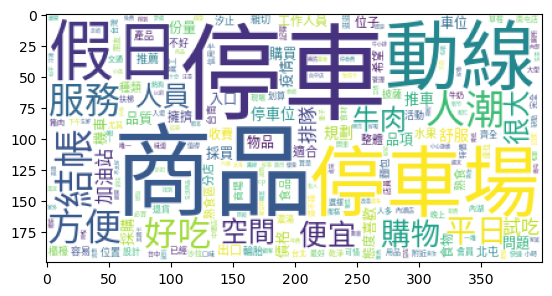

In [12]:
font = 'SourceHanSansTWRegular-220427-102703.otf'
my_wordcloud = WordCloud(background_color = 'white',
                        max_words = 300,
                        font_path = font).generate_from_frequencies(result.T.sum(axis = 1))

plt.imshow(my_wordcloud)

⇡ 詞彙越重要tfidf越高，文字雲中顯示會越大

### 初步結論
由上可知所有留言中主要的關鍵字為「停車、動線、人潮、商品、方便、服務」等面向的字詞，但無法更深入的瞭解討論的內容，如：服務是好或差、停車或賣場動線規劃是好還是需改進，因此，將繼續針對「大家討論的主題」、「風向者」等進行深入瞭解。

### 風向者偵測

In [13]:
# 依據獲讚數排序
df = data.groupby(['username'])['review'].count().reset_index()
df2 = data.groupby(['username'])['rate'].mean().reset_index()
df3 = data.groupby(['username'])['likes'].sum().reset_index()
final = pd.merge(df, df2, on = 'username', how = 'inner')
final = pd.merge(final, df3, on = 'username', how = 'inner')
kol = final.sort_values(by = 'likes', ascending = False)
kol.iloc[:5,:]

,username,review,rate,likes
462,戴立綱氣象,5,5.0,24
271,Versace,1,5.0,24
352,ququach __,1,4.0,21
398,台中RJ,2,4.5,21
140,Jimmy Chen,3,4.0,21


⇡ 由上可看到likes(獲讚數)前5名的使用者，從rate(評論星評)可以看到平均分數維持在4-5顆星，代表賣場整體表驗還不錯

In [14]:
# 依據評論星評排序
bad = final.sort_values(by = ['rate','likes'], ascending = [True,False])
bad.iloc[:5,:]

,username,review,rate,likes
149,JuiEn Tsai,1,1.0,13
170,Lala soo,1,1.0,9
199,Mia Mia,1,1.0,8
290,Wl Wl,1,1.0,8
373,wen chieh,1,1.0,8


⇡ 由上可看到rate(評論星評)最低且likes(獲讚數)最多的前5名的使用者，可以從他們的留言中瞭解公司最需要改進的部分
- 台南店:員工訓練問題(熟食部人員、流程需加強訓練/會員被擋在門口)
- 新莊店:收銀員行銷方式不滿(拐騙辦黑鑽卡)
- 南崁店:賣場動線、商品擺放需改進(上下手扶梯標示不清、東西不好找(玩具紅酒放一起))
- 東西漲價

### 主題挖掘

In [15]:
data['review_cut'] = data['review_cut'].astype(str)

#文字資料向量化
cv = CountVectorizer(min_df = 1, stop_words = stop_words)
s_matrix = cv.fit_transform(data['review_cut'])
featureNames = cv.get_feature_names_out()

# LDA模型
LDA = LatentDirichletAllocation(n_components = 3, random_state = 5)
lda = LDA.fit(s_matrix)

#三大主題
for idx, topic in enumerate(lda.components_):
    print('Topic', idx, ' '.join(featureNames[i] for i in topic.argsort()[:-10 -1:-1]))


/Users/pennykuo/opt/anaconda3/envs/for_tibame/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['00', '21', '若果'] not in stop_words.
  warnings.warn(


Topic 0 商品 停車 結帳 動線 服務 停車場 假日 人潮 人員 空間
Topic 1 商品 停車場 人潮 平日 好吃 停車 方便 假日 結帳 動線
Topic 2 停車場 服務 商品 好吃 輪胎 便宜 購物 牛肉 停車 疫情


由上分成三個主題，分別是Topic0、Topic1、Topic2，  
第一個主題主要討論的是`商品及人員服務相關的話題`，像是提供的商品好吃、價格便宜，  
第二及第三個主題重疊性較高，主要在`討論假日、停車塲、動線及人潮、結帳的話題`，  
從中可以知道假日時，好市多因為人潮多，導致停車場常被停滿，結帳常需要排隊，動線規劃可以再加強